In [ ]:
!pip install tensorflow==2.10 wandb tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 KB 21.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.9/178.9 KB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 11.6 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3

In [ ]:
from tensorflow.keras.layers import Multiply, LeakyReLU, Conv2D, Dropout , Concatenate ,UpSampling2D, SpatialDropout2D , GlobalAveragePooling2D  , Normalization, BatchNormalization , Activation   , AveragePooling2D  , MaxPooling2D, ZeroPadding2D , Dense , Add , ZeroPadding2D  , Input ,Flatten , Reshape
from tensorflow.keras.models import Model , Sequential
import tensorflow as tf 
import tensorflow.keras.backend as K 
from tensorflow.keras import mixed_precision
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import ReduceLROnPlateau
import gc
from sklearn.model_selection import train_test_split
# mixed_precision.set_global_policy('mixed_float16')
IMG_SIZE = 28
import matplotlib.pyplot as plt
tf.random.set_seed(42)
import wandb 



In [ ]:
tf

<module 'tensorflow' from '/usr/local/lib/python3.8/dist-packages/tensorflow/__init__.py'>

In [ ]:


# num_img_per_class = 5
# latent_dim =128
# corelabels = tf.range(0,10 ) 
# print(corelabels)
# # print([num_img_per_class]*tf.size(corelabels))
# repeated = tf.repeat(corelabels,  num_img_per_class, axis = 0 ) 
# print(repeated)
# labels = tf.keras.utils.to_categorical(repeated , 10) 



# random_latent_vectors = tf.random.normal(shape=(num_img_per_class*10, latent_dim))




# tf.concat([random_latent_vectors ,labels ] , axis = 1 )

In [ ]:
import tensorflow.keras.models as KM
import tensorflow as tf


import warnings

from keras.applications.inception_v3 import InceptionV3
from keras import backend as K
import numpy as np

class ImageWandbLogger(tf.keras.callbacks.Callback):
	def __init__(self, num_img_per_class=5, latent_dim=128):
		self.num_img_per_class = num_img_per_class
		self.latent_dim = latent_dim

	def on_epoch_end(self, epoch, logs=None):

		corelabels = tf.range(0,10 ) 
		labels = tf.keras.utils.to_categorical(tf.repeat(corelabels, self.num_img_per_class, axis = 0 ) , 10 )
		random_latent_vectors = tf.random.normal(shape=(self.num_img_per_class*10, self.latent_dim))
		generated_images = self.model.generator(tf.concat([random_latent_vectors ,labels ] , axis = 1 ))
		generated_images = (generated_images * 127.5) + 127.5
		images = []

		for i in range(self.num_img_per_class * 10 ):
			img = generated_images[i].numpy()
			img = tf.keras.preprocessing.image.array_to_img(img)
			images.append(wandb.Image(img, caption = f'img:{i}\nepoch = {epoch}' ))

		try:
			wandb.log({'Generated Images' : images})
			print("Successfully logged images")
		except Exception as e:
			print(e)
			print('Logging failed')



def resize(img):
	return tf.image.resize(img, (75,75,3))

class FIDCallBack(tf.keras.callbacks.Callback):
	def on_epoch_start(self, epoch, logs=None):
		model = self.model 



		try:
			next(real_images)
			resized = realimages.map(resize)
		except:
			resized = resize(real_images)


		# real_images = model.images.map()


		noise = tf.random.normal(shape=(128, 100))
		fid_score = FID( model.generator  , (-1,1 ))((real_images, noise))
		self.model.fid_history['epoch'].append(epoch)
		self.model.fid_history['fidscore'].append(fid_score)
		if logs:
			logs['fidscore'] = fid_score
		print("End epoch {} of training FID is : {}".format(epoch, fid_score))
from tensorflow import keras 
from tensorflow.keras import layers 
class KID(keras.metrics.Metric):
	#https://keras.io/examples/generative/gan_ada/ 
    def __init__(self, name="kid", **kwargs):
        super().__init__(name=name, **kwargs)

        # KID is estimated per batch and is averaged across batches
        self.kid_tracker = keras.metrics.Mean()

        # a pretrained InceptionV3 is used without its classification layer
        # transform the pixel values to the 0-255 range, then use the same
        # preprocessing as during pretraining
        self.encoder = keras.Sequential(
            [
                layers.InputLayer(input_shape=(32, 32, 3)),
                # layers.Rescaling(255.0),
                layers.Resizing(height=75, width=75),
                layers.Lambda(keras.applications.inception_v3.preprocess_input),
                keras.applications.InceptionV3(
                    include_top=False,
                    input_shape=(75, 75, 3),
                    weights="imagenet",
                ),
                layers.GlobalAveragePooling2D(),
            ],
            name="inception_encoder",
        )

    def polynomial_kernel(self, features_1, features_2):
        feature_dimensions = tf.cast(tf.shape(features_1)[1], dtype=tf.float32)
        return (features_1 @ tf.transpose(features_2) / feature_dimensions + 1.0) ** 3.0

    def update_state(self, real_images, generated_images, sample_weight=None):
        real_features = self.encoder(real_images, training=False)
        generated_features = self.encoder(generated_images, training=False)

        # compute polynomial kernels using the two sets of features
        kernel_real = self.polynomial_kernel(real_features, real_features)
        kernel_generated = self.polynomial_kernel(
            generated_features, generated_features
        )
        kernel_cross = self.polynomial_kernel(real_features, generated_features)

        # estimate the squared maximum mean discrepancy using the average kernel values
        batch_size = tf.shape(real_features)[0]
        batch_size_f = tf.cast(batch_size, dtype=tf.float32)
        mean_kernel_real = tf.reduce_sum(kernel_real * (1.0 - tf.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        mean_kernel_generated = tf.reduce_sum(
            kernel_generated * (1.0 - tf.eye(batch_size))
        ) / (batch_size_f * (batch_size_f - 1.0))
        mean_kernel_cross = tf.reduce_mean(kernel_cross)
        kid = mean_kernel_real + mean_kernel_generated - 2.0 * mean_kernel_cross

        # update the average KID estimate
        self.kid_tracker.update_state(kid)

    def result(self):
        return self.kid_tracker.result()

    def reset_state(self):
        self.kid_tracker.reset_state()

class ImageLogger(tf.keras.callbacks.Callback):
	def __init__(self, num_row=10 , num_col = 5, latent_dim=128,interval = 5):
		self.num_rows = num_row
		self.latent_dim = latent_dim
		self.num_cols = num_col
		self.interval= interval


	def on_epoch_end(self, epoch, logs=None):
		if epoch % self.interval == 0:



			random_latent_vectors = tf.random.normal(shape=(self.num_rows * self.num_cols , self.latent_dim))
			
	
			generated_images = self.model.generator([random_latent_vectors ,tf.repeat(tf.range(0,10) ,5  , axis = 0 ) ]).numpy() 
			generated_images = (generated_images +1 ) /2 
			plt.figure(figsize=(self.num_cols * 1.0, self.num_rows * 1.0))
	
			for row in range(self.num_rows):
				for col in range(self.num_cols):
					index = row * self.num_cols + col
					# print(generated_images[index] )
					plt.subplot(self.num_rows, self.num_cols, index + 1)
					plt.imshow(generated_images[index] )
					plt.axis("off")
			plt.tight_layout()
			plt.show()
			plt.close()
import os 
import shutil
class WandbModelLogger(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs=None):

		# print('logs', logs)
		if isinstance( logs, dict):

			wandb.log( {**logs, **dict( epoch = epoch )})
		if 'val_kid' in logs:

			disstr = f"Discriminator-Epoch{epoch},KID={logs['val_kid']}"
			genstr = f"Generator-Epoch{epoch},KID={logs['val_kid']}"
		else:

			disstr = f"Discriminator-Epoch{epoch}"
			genstr = f"Generator-Epoch{epoch}"
		
		self.model.discriminator.save(disstr,save_format="tf")
		self.model.generator.save(genstr	, save_format="tf")
		# self.model.save(self.filepath[:-3], overwrite=True, save_format="tf")

        # Log the model as artifact.
		dis_name = wandb.util.make_artifact_name_safe(f"Discriminator-{wandb.run.name}")
		gen_name = wandb.util.make_artifact_name_safe(f"Generator-{wandb.run.name}")
		dis_artifact = wandb.Artifact(dis_name, type="model")
		gen_artifact = wandb.Artifact(gen_name, type="model")
  


		dis_artifact.add_dir(disstr)
		gen_artifact.add_dir(genstr)
		wandb.run.log_artifact(dis_artifact, aliases=["latest", f"Discriminator_epoch_{epoch}"])
		wandb.run.log_artifact(gen_artifact, aliases=["latest", f"Generator_epoch_{epoch}"])

		# Remove the SavedModel from wandb dir as we don't want to log it to save memory.
		shutil.rmtree(disstr)
		shutil.rmtree(genstr)



#https://medium.com/dive-into-ml-ai/customization-of-model-fit-to-write-a-combined-discriminator-generator-gan-trainer-in-keras-524bce10cf66
class GAN(KM.Model):
	def __init__(self, discriminator, generator , latdim , discriminator_extra_steps =4 , img_size = 32, num_classes = 10, *args):
		super().__init__()
		self.discriminator = discriminator
		self.generator= generator
		self.latent_dim = latdim
		self.discriminator_extra_steps = tf.constant(discriminator_extra_steps)
		self.image_size = img_size 
		self.num_classes = num_classes 
		self.counter = None 

		self.gen_loss = None

		self.fid_history = dict(epoch = list() , fidscore = list() ) 
		self.d_loss_tracker = keras.metrics.Mean()
		self.g_loss_tracker = keras.metrics.Mean()
  

		


	def compile(self, optimizers, loss):
		super().compile()

		# Optimizer for discriminator
		self.d_optimizer = optimizers["d_optimizer"]
		# Optimizer for generator
		self.g_optimizer = optimizers["g_optimizer"]

		# Loss for the main objective
		self.g_loss = loss["g_loss"]
		# Discriminator loss
		self.d_loss = loss["d_loss"]
		self.kid = KID()

		# self.metrics = metrics 

	def fit(self, *args, **kwargs):
		self.img = args[0] if len(args) >= 1 else kwargs['x']
		self.fid_history['epoch'] = list() 
		self.fid_history['fidscore'] = list() 
  
		return super().fit( *args, **kwargs)
		# def forward(self, discriminator_prediction_real: torch.Tensor,
		#         discriminator_prediction_fake: torch.Tensor) -> torch.Tensor:
		# """
		# Forward pass to compute the regularization
		# :param discriminator_prediction_real: (torch.Tensor) Real prediction of the discriminator
		# :param discriminator_prediction_fake: (torch.Tensor) Fake prediction of the discriminator
		# """
		# regularization_loss = (discriminator_prediction_real - HYPERPARAMETERS["rlc_af"]).norm(dim=-1).pow(2).mean() \
		#                       + (discriminator_prediction_fake - HYPERPARAMETERS["rlc_ar"]).norm(dim=-1).pow(2).mean()
		# return HYPERPARAMETERS["rlc_w"] * regularization_loss

	# def RLC_regularisation(predreal, predfake):
	# 	param = tf.mean(tf.math.power((predreal - self.rlc_real_param ).norm(),2)) + tf.mean(tf.math.power((predfake - self.rlc_fake_param ).norm(),2)))
  #       return param*self.rlc_factor



	def test_step(self, real_images):
		if isinstance(real_images, tuple):
			labels = real_images[1]
			real_images = real_images[0]
			# labels = 
		batch_size = tf.shape(real_images)[0]
		latent_samples = tf.random.normal(shape=(batch_size, self.latent_dim) ) 
		generated_images = self.generator([latent_samples , labels], training=False)
     

		self.kid.update_state(real_images, (generated_images+1)/2)

		# only KID is measured during the evaluation phase for computational efficiency
		return {self.kid.name: self.kid.result()}



	def train_step(self, data):
		#https://keras.io/examples/generative/conditional_gan/
	
		real_images, class_labels = data
		batch_size = tf.shape(real_images)[0]


	
		random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim) ) 


		generated_images = self.generator([random_latent_vectors , class_labels], training = True)
  

	

		with tf.GradientTape() as tape:
			predictions_real = self.discriminator([real_images , class_labels], training = True)
			predictions_false = self.discriminator([generated_images , class_labels] , training = True)
		
			d_loss = self.d_loss(batch_size, predictions_real ,predictions_false  , real_images, generated_images, class_labels , self.discriminator )

			
			
		grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
		# grads = self.d_optimizer.get_unscaled_gradients( scaled_grads)
		self.d_optimizer.apply_gradients(
			zip(grads, self.discriminator.trainable_weights)
		)
		self.d_loss_tracker.update_state(d_loss)

		del grads , tape


		# Sample random points in the latent space


		#train discriminator 


		if self.counter is None:

			self.counter = tf.Variable(0 , trainable =False)
   

		if self.gen_loss is None:
			self.gen_loss  = tf.Variable(0.0, trainable =False)
   
		def inner_train_gen():
			random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim)) 



			with tf.GradientTape() as tape:
				fakeimgs = self.generator([random_latent_vectors , class_labels ],  training = True) 
		
				predictions = self.discriminator([fakeimgs , class_labels],  training = True )
				g_loss = self.g_loss( predictions)
			
			
			
			self.gen_loss.assign(g_loss)
			grads  = tape.gradient(g_loss, self.generator.trainable_weights)
			self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
			self.g_loss_tracker.update_state(self.gen_loss)
			del predictions, grads  , tape 
			
		
		
		tf.cond( self.counter % self.discriminator_extra_steps ==0 , inner_train_gen , lambda :None  ) 
			
		
		
		

		self.counter.assign_add(1)



		
		return {"d_loss": self.d_loss_tracker.result(), "g_loss": self.g_loss_tracker.result()}







from tensorflow.keras.layers import  Embedding


def downsample_block(x,filters):
    x = Conv2D(filters, 5, strides=2, padding='same', use_bias=True)(x)#larger kernel size of 5 avoids overfitting
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)#use dropout instead of bn to regularise the wgangp discriminator
    return x


def discriminator():
    inputimage = Input(shape=(32,32,3))
    x = downsample_block(inputimage,64)
    x = downsample_block(x,128)
    x = downsample_block(x,256)
    x = downsample_block(x,512)
    label = Input(shape=(1, ))
    embedded_label = Flatten()(Embedding(10, 2048)(label))
    x = Flatten()(x)
    x = Multiply()([x, embedded_label])
    x = Dropout(0.2)(x)
    x = Dense(1)(x)
    return      Model([inputimage,label], x)
     




def upsample_block(x,filters):
    x = UpSampling2D(2)(x)
    x = Conv2D(filters, 3, strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    return x


def generator():
    latent_dim = 128
    inputnoise = Input(shape=(latent_dim,))
    label = Input(shape=(1, ))
    embbededlabel = Flatten()(Embedding(10, latent_dim)(label))
    model_input = Multiply()([inputnoise, embbededlabel])

    x = Dense(4 * 4 * latent_dim, use_bias=False)(model_input)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Reshape((4, 4, latent_dim))(x)
    x = upsample_block(x,128)
    x = upsample_block(x, 64 )
    x= UpSampling2D(2)(x)
    x= Conv2D( 3,(3,3), strides = 1 , padding = 'same', use_bias = False   )(x)
    x= BatchNormalization()(x)
    x = Activation('tanh')(x)
    return          Model([inputnoise,label], x)




In [ ]:
discriminator().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   4864        ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 16, 16, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 16, 16, 64)   0           ['leaky_re_lu[0][0]']            
                                                                                              

In [ ]:
generator().summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 128)       1280        ['input_4[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 flatten_2 (Flatten)            (None, 128)          0           ['embedding_1[0][0]']            
                                                                                            

### Adding Conditioning 
https://arxiv.org/pdf/1701.00160.pdf
- Adding conditioning to labels to make the generation of gan more specific
- Using embedding layer for both discriminator and generator 


### Problems with Binary Cross Entropy Loss
https://developers.google.com/machine-learning/gan/problems
- Instability during training , the gradients can vanish and generator stops improving
- When the discrminator gets too good, it is unable to provide feedback to generator

### Loss Function: Wasserstein Loss (WGAN)
<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-25_at_2.53.08_PM.png" alt="Alternative text" height = 200 width = 200/>
<br/>
- An approximation of the Earth-Mover's distance that ensures that gradients are smoother compared to the original binary cross entropy loss
- Instead of using sigmoid activation in the last layer and classifying images as true and false directly,  the critic in the WGAN assigns values (from -infinity to infinity) to real and fake images and the discrminator loss function is:

`f.reduce_mean(fake_predictions) - tf.reducem_mean(real_predictions)` which maximises the difference between the distribution of real and fake images

#### 1-Lipschitz Continuity
- The Lipschitz continuity should be enforced to prevent gradients from becoming too large

> Weight Clipping
- Weight clipping sets explicit limits that the weights cannot exceed
- It will limit the performance of the gan espescially, as weights cannot exceed a certain fixed value

> Gradient Penalty 
https://arxiv.org/abs/1704.00028v3
- adds an extra term of gradient penalty  by using interpolated images
- It penalize the norm of gradient of the discrminator 
- Found experimentally to produce better results than weight clipping


In [ ]:


# self.d_loss(batch_size, predictions_real ,predictions_false , class_labels , self.discriminator )
@tf.function 
def gradient_penalty( batch_size, real_images, fake_images  , class_labels, discriminator):
    """Calculates the gradient penalty.

    This loss is calculated on an interpolated image
    and added to the discriminator loss.
    """
    # Get the interpolated image
    alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
    diff = fake_images - real_images
    interpolated = real_images + alpha * diff
    # print(interpolated.shape)

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        # 1. Get the discriminator output for this interpolated image.
        pred = discriminator([interpolated , class_labels], training=True)

    # 2. Calculate the gradients w.r.t to this interpolated image.
    grads = gp_tape.gradient(pred, [interpolated])[0]
    # 3. Calculate the norm of the gradients.
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3])+1e-24)
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp

@tf.function 
def discriminator_loss(batch_size, real_img_pred, fake_img_pred, real_img, fake_img   , classes, discriminator ):
    real_loss = tf.reduce_mean(real_img_pred)
    fake_loss = tf.reduce_mean(fake_img_pred)
    gp =  gradient_penalty(batch_size, real_img, fake_img  , classes, discriminator )
    return   (fake_loss - real_loss  )+ 10.0*gp  


# Define the loss functions for the generator.
def generator_loss(fake_img):
	return -tf.reduce_mean(fake_img)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yh1234. Use `wandb login --relogin` to force relogin


Epoch 1/70
782/782 [==============================] - ETA: 0s - d_loss: -7.0838 - g_loss: 24.1158

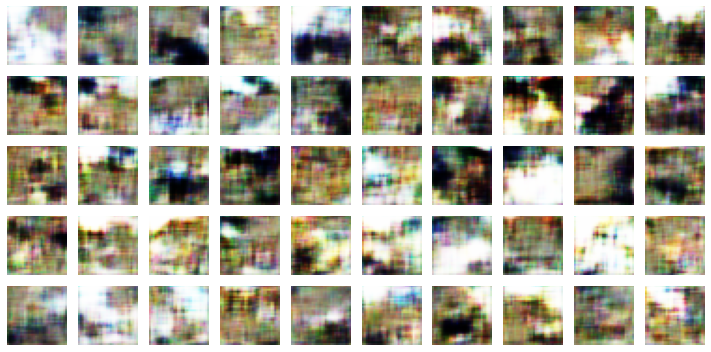

wandb: Adding directory to artifact (./Discriminator-Epoch0,KID=0.014611377380788326)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch0,KID=0.014611377380788326)... Done. 0.0s


782/782 [==============================] - 80s 88ms/step - d_loss: -7.0844 - g_loss: 24.1156 - val_kid: 0.0146
Epoch 2/70
781/782 [============================>.] - ETA: 0s - d_loss: -4.0473 - g_loss: 10.0140

wandb: Adding directory to artifact (./Discriminator-Epoch1,KID=0.015182738192379475)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch1,KID=0.015182738192379475)... Done. 0.0s


782/782 [==============================] - 65s 83ms/step - d_loss: -4.0461 - g_loss: 10.0161 - val_kid: 0.0152
Epoch 3/70
782/782 [==============================] - ETA: 0s - d_loss: -2.5945 - g_loss: 15.0324

wandb: Adding directory to artifact (./Discriminator-Epoch2,KID=0.01366383209824562)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch2,KID=0.01366383209824562)... Done. 0.0s


782/782 [==============================] - 64s 82ms/step - d_loss: -2.5944 - g_loss: 15.0302 - val_kid: 0.0137
Epoch 4/70
781/782 [============================>.] - ETA: 0s - d_loss: -2.1323 - g_loss: 8.8675

wandb: Adding directory to artifact (./Discriminator-Epoch3,KID=0.009855920448899269)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch3,KID=0.009855920448899269)... Done. 0.0s


782/782 [==============================] - 64s 82ms/step - d_loss: -2.1323 - g_loss: 8.8618 - val_kid: 0.0099
Epoch 5/70
781/782 [============================>.] - ETA: 0s - d_loss: -1.8616 - g_loss: 1.7453

wandb: Adding directory to artifact (./Discriminator-Epoch4,KID=0.00881026778370142)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch4,KID=0.00881026778370142)... Done. 0.0s


782/782 [==============================] - 64s 82ms/step - d_loss: -1.8618 - g_loss: 1.7450 - val_kid: 0.0088
Epoch 6/70
781/782 [============================>.] - ETA: 0s - d_loss: -2.0229 - g_loss: 0.3147

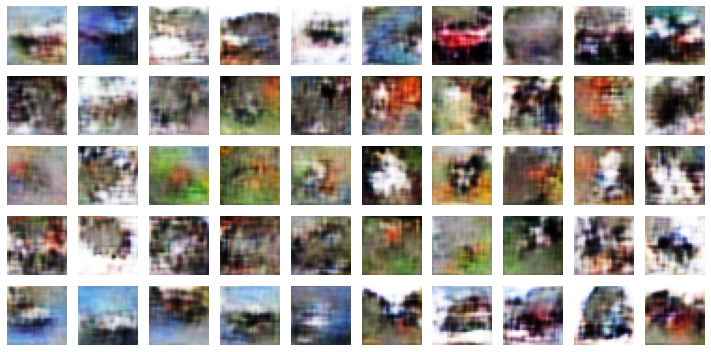

wandb: Adding directory to artifact (./Discriminator-Epoch5,KID=0.00699991500005126)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch5,KID=0.00699991500005126)... Done. 0.0s


782/782 [==============================] - 65s 84ms/step - d_loss: -2.0229 - g_loss: 0.3169 - val_kid: 0.0070
Epoch 7/70
781/782 [============================>.] - ETA: 0s - d_loss: -1.8234 - g_loss: 4.9873

wandb: Adding directory to artifact (./Discriminator-Epoch6,KID=0.00481208274140954)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch6,KID=0.00481208274140954)... Done. 0.0s


782/782 [==============================] - 64s 82ms/step - d_loss: -1.8233 - g_loss: 4.9868 - val_kid: 0.0048
Epoch 8/70
781/782 [============================>.] - ETA: 0s - d_loss: -1.7945 - g_loss: 4.4897

wandb: Adding directory to artifact (./Discriminator-Epoch7,KID=0.003951935097575188)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch7,KID=0.003951935097575188)... Done. 0.0s


782/782 [==============================] - 64s 82ms/step - d_loss: -1.7944 - g_loss: 4.4905 - val_kid: 0.0040
Epoch 9/70
781/782 [============================>.] - ETA: 0s - d_loss: -1.8443 - g_loss: 4.0543

wandb: Adding directory to artifact (./Discriminator-Epoch8,KID=0.004018127452582121)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch8,KID=0.004018127452582121)... Done. 0.0s


782/782 [==============================] - 65s 83ms/step - d_loss: -1.8445 - g_loss: 4.0539 - val_kid: 0.0040
Epoch 10/70
781/782 [============================>.] - ETA: 0s - d_loss: -1.9772 - g_loss: 4.1902

wandb: Adding directory to artifact (./Discriminator-Epoch9,KID=0.0025720838457345963)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch9,KID=0.0025720838457345963)... Done. 0.0s


782/782 [==============================] - 64s 82ms/step - d_loss: -1.9770 - g_loss: 4.1889 - val_kid: 0.0026
Epoch 11/70
781/782 [============================>.] - ETA: 0s - d_loss: -1.8652 - g_loss: 3.4483

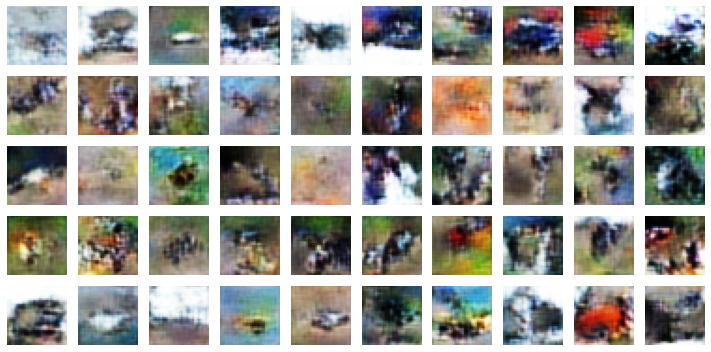

wandb: Adding directory to artifact (./Discriminator-Epoch10,KID=0.003614705055952072)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch10,KID=0.003614705055952072)... Done. 0.0s


782/782 [==============================] - 66s 85ms/step - d_loss: -1.8653 - g_loss: 3.4479 - val_kid: 0.0036
Epoch 12/70
781/782 [============================>.] - ETA: 0s - d_loss: -1.8448 - g_loss: 2.1472

wandb: Adding directory to artifact (./Discriminator-Epoch11,KID=0.003085300326347351)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch11,KID=0.003085300326347351)... Done. 0.0s


782/782 [==============================] - 65s 83ms/step - d_loss: -1.8447 - g_loss: 2.1464 - val_kid: 0.0031
Epoch 13/70
781/782 [============================>.] - ETA: 0s - d_loss: -1.8150 - g_loss: 3.4453

wandb: Adding directory to artifact (./Discriminator-Epoch12,KID=0.0034638908691704273)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch12,KID=0.0034638908691704273)... Done. 0.0s


782/782 [==============================] - 65s 83ms/step - d_loss: -1.8150 - g_loss: 3.4438 - val_kid: 0.0035
Epoch 14/70
781/782 [============================>.] - ETA: 0s - d_loss: -1.8002 - g_loss: 3.5690

wandb: Adding directory to artifact (./Discriminator-Epoch13,KID=0.0019046880770474672)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch13,KID=0.0019046880770474672)... Done. 0.0s


782/782 [==============================] - 65s 83ms/step - d_loss: -1.8002 - g_loss: 3.5695 - val_kid: 0.0019
Epoch 15/70
781/782 [============================>.] - ETA: 0s - d_loss: -1.7387 - g_loss: 2.4628

wandb: Adding directory to artifact (./Discriminator-Epoch14,KID=0.001966926036402583)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch14,KID=0.001966926036402583)... Done. 0.0s


782/782 [==============================] - 65s 83ms/step - d_loss: -1.7385 - g_loss: 2.4606 - val_kid: 0.0020
Epoch 16/70
781/782 [============================>.] - ETA: 0s - d_loss: -1.5828 - g_loss: 1.6575

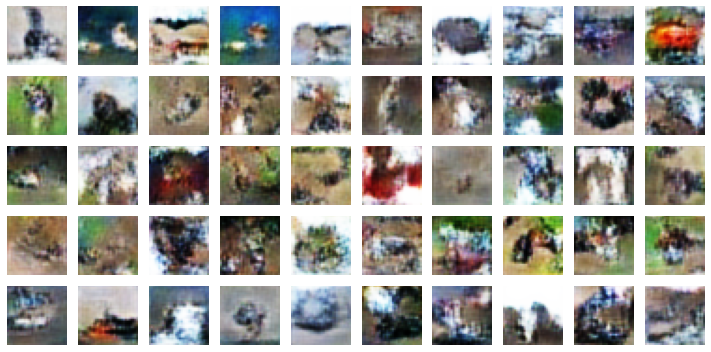

wandb: Adding directory to artifact (./Discriminator-Epoch15,KID=0.001588517683558166)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch15,KID=0.001588517683558166)... Done. 0.0s


782/782 [==============================] - 66s 84ms/step - d_loss: -1.5828 - g_loss: 1.6570 - val_kid: 0.0016
Epoch 17/70
781/782 [============================>.] - ETA: 0s - d_loss: -1.6424 - g_loss: 1.2319

wandb: Adding directory to artifact (./Discriminator-Epoch16,KID=0.002155723050236702)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch16,KID=0.002155723050236702)... Done. 0.0s


782/782 [==============================] - 64s 81ms/step - d_loss: -1.6422 - g_loss: 1.2319 - val_kid: 0.0022
Epoch 18/70
781/782 [============================>.] - ETA: 0s - d_loss: -1.6059 - g_loss: -0.6437

wandb: Adding directory to artifact (./Discriminator-Epoch17,KID=0.00231173075735569)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch17,KID=0.00231173075735569)... Done. 0.0s


782/782 [==============================] - 64s 82ms/step - d_loss: -1.6059 - g_loss: -0.6454 - val_kid: 0.0023
Epoch 19/70
781/782 [============================>.] - ETA: 0s - d_loss: -1.4868 - g_loss: 1.8453

wandb: Adding directory to artifact (./Discriminator-Epoch18,KID=0.0009933641413226724)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch18,KID=0.0009933641413226724)... Done. 0.0s


782/782 [==============================] - 64s 82ms/step - d_loss: -1.4866 - g_loss: 1.8443 - val_kid: 9.9336e-04
Epoch 20/70
781/782 [============================>.] - ETA: 0s - d_loss: -1.2644 - g_loss: -0.9866

wandb: Adding directory to artifact (./Discriminator-Epoch19,KID=0.0007195260259322822)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch19,KID=0.0007195260259322822)... Done. 0.0s


782/782 [==============================] - 64s 82ms/step - d_loss: -1.2646 - g_loss: -0.9876 - val_kid: 7.1953e-04
Epoch 21/70
781/782 [============================>.] - ETA: 0s - d_loss: -1.3547 - g_loss: -0.6721

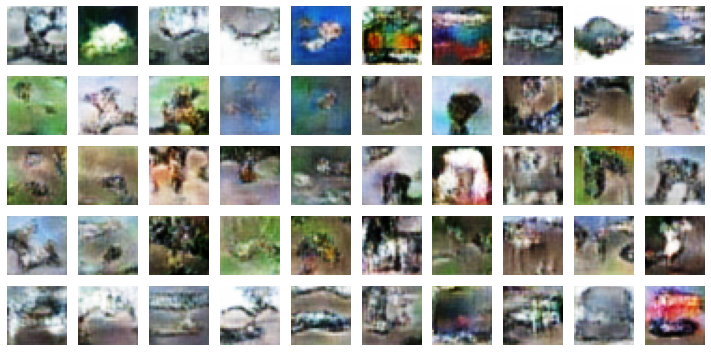

wandb: Adding directory to artifact (./Discriminator-Epoch20,KID=0.0007207469316199422)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch20,KID=0.0007207469316199422)... Done. 0.0s


782/782 [==============================] - 66s 85ms/step - d_loss: -1.3547 - g_loss: -0.6721 - val_kid: 7.2075e-04
Epoch 22/70
781/782 [============================>.] - ETA: 0s - d_loss: -1.2603 - g_loss: -0.2989

wandb: Adding directory to artifact (./Discriminator-Epoch21,KID=0.0006316907820291817)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch21,KID=0.0006316907820291817)... Done. 0.0s


782/782 [==============================] - 68s 87ms/step - d_loss: -1.2604 - g_loss: -0.3001 - val_kid: 6.3169e-04
Epoch 23/70
781/782 [============================>.] - ETA: 0s - d_loss: -1.3327 - g_loss: -2.5107

wandb: Adding directory to artifact (./Discriminator-Epoch22,KID=0.00026778201572597027)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch22,KID=0.00026778201572597027)... Done. 0.0s


782/782 [==============================] - 63s 81ms/step - d_loss: -1.3327 - g_loss: -2.5153 - val_kid: 2.6778e-04
Epoch 24/70
781/782 [============================>.] - ETA: 0s - d_loss: -1.1279 - g_loss: -2.3871

wandb: Adding directory to artifact (./Discriminator-Epoch23,KID=0.000402347301132977)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch23,KID=0.000402347301132977)... Done. 0.0s


782/782 [==============================] - 64s 82ms/step - d_loss: -1.1280 - g_loss: -2.3882 - val_kid: 4.0235e-04
Epoch 25/70
781/782 [============================>.] - ETA: 0s - d_loss: -1.1130 - g_loss: -4.0085

wandb: Adding directory to artifact (./Discriminator-Epoch24,KID=0.0012946645729243755)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch24,KID=0.0012946645729243755)... Done. 0.0s


782/782 [==============================] - 64s 81ms/step - d_loss: -1.1130 - g_loss: -4.0049 - val_kid: 0.0013
Epoch 26/70
781/782 [============================>.] - ETA: 0s - d_loss: -1.2888 - g_loss: -0.4520

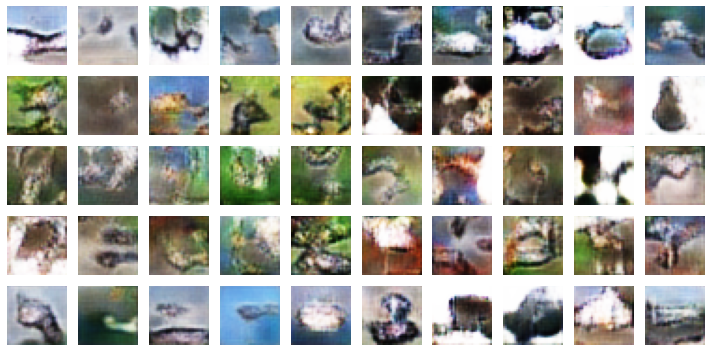

wandb: Adding directory to artifact (./Discriminator-Epoch25,KID=0.0004958681529387832)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch25,KID=0.0004958681529387832)... Done. 0.0s


782/782 [==============================] - 66s 84ms/step - d_loss: -1.2885 - g_loss: -0.4521 - val_kid: 4.9587e-04
Epoch 27/70
781/782 [============================>.] - ETA: 0s - d_loss: -1.2125 - g_loss: -2.3904

wandb: Adding directory to artifact (./Discriminator-Epoch26,KID=0.00110906851477921)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch26,KID=0.00110906851477921)... Done. 0.0s


782/782 [==============================] - 63s 81ms/step - d_loss: -1.2126 - g_loss: -2.3914 - val_kid: 0.0011
Epoch 28/70
781/782 [============================>.] - ETA: 0s - d_loss: -1.2892 - g_loss: -3.3627

wandb: Adding directory to artifact (./Discriminator-Epoch27,KID=0.0002399250224698335)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch27,KID=0.0002399250224698335)... Done. 0.0s


782/782 [==============================] - 66s 84ms/step - d_loss: -1.2888 - g_loss: -3.3661 - val_kid: 2.3993e-04
Epoch 29/70
781/782 [============================>.] - ETA: 0s - d_loss: -1.0508 - g_loss: -2.2867

wandb: Adding directory to artifact (./Discriminator-Epoch28,KID=0.0002174802648369223)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch28,KID=0.0002174802648369223)... Done. 0.0s


782/782 [==============================] - 64s 82ms/step - d_loss: -1.0506 - g_loss: -2.2868 - val_kid: 2.1748e-04
Epoch 30/70
781/782 [============================>.] - ETA: 0s - d_loss: -1.0332 - g_loss: -2.8217

wandb: Adding directory to artifact (./Discriminator-Epoch29,KID=0.0004084945539943874)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch29,KID=0.0004084945539943874)... Done. 0.0s


782/782 [==============================] - 64s 82ms/step - d_loss: -1.0331 - g_loss: -2.8200 - val_kid: 4.0849e-04
Epoch 31/70
781/782 [============================>.] - ETA: 0s - d_loss: -1.1333 - g_loss: -3.8945

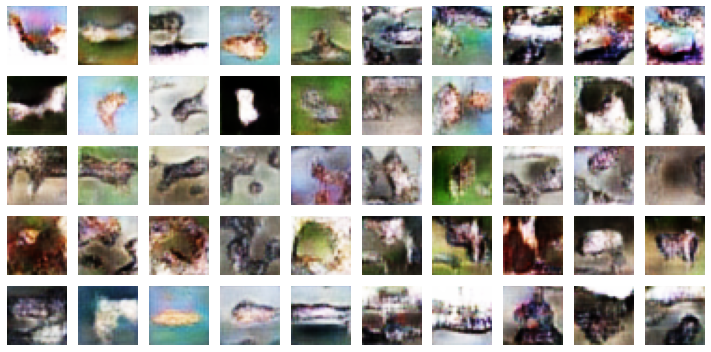

wandb: Adding directory to artifact (./Discriminator-Epoch30,KID=0.0011217882856726646)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch30,KID=0.0011217882856726646)... Done. 0.0s


782/782 [==============================] - 65s 83ms/step - d_loss: -1.1335 - g_loss: -3.8994 - val_kid: 0.0011
Epoch 32/70
781/782 [============================>.] - ETA: 0s - d_loss: -0.9833 - g_loss: -8.9281

wandb: Adding directory to artifact (./Discriminator-Epoch31,KID=0.000500521098729223)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch31,KID=0.000500521098729223)... Done. 0.0s


782/782 [==============================] - 64s 82ms/step - d_loss: -0.9835 - g_loss: -8.9267 - val_kid: 5.0052e-04
Epoch 33/70
782/782 [==============================] - ETA: 0s - d_loss: -1.0293 - g_loss: -9.9208

wandb: Adding directory to artifact (./Discriminator-Epoch32,KID=0.0011229545343667269)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch32,KID=0.0011229545343667269)... Done. 0.0s


782/782 [==============================] - 64s 82ms/step - d_loss: -1.0293 - g_loss: -9.9216 - val_kid: 0.0011
Epoch 34/70
781/782 [============================>.] - ETA: 0s - d_loss: -0.8883 - g_loss: -3.9083

wandb: Adding directory to artifact (./Discriminator-Epoch33,KID=0.0015187293756753206)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch33,KID=0.0015187293756753206)... Done. 0.0s


782/782 [==============================] - 64s 81ms/step - d_loss: -0.8886 - g_loss: -3.9101 - val_kid: 0.0015
Epoch 35/70
781/782 [============================>.] - ETA: 0s - d_loss: -1.1795 - g_loss: -8.0245

wandb: Adding directory to artifact (./Discriminator-Epoch34,KID=0.0006373581709340215)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch34,KID=0.0006373581709340215)... Done. 0.0s


782/782 [==============================] - 65s 83ms/step - d_loss: -1.1792 - g_loss: -8.0208 - val_kid: 6.3736e-04
Epoch 36/70
781/782 [============================>.] - ETA: 0s - d_loss: -0.7323 - g_loss: -2.8409

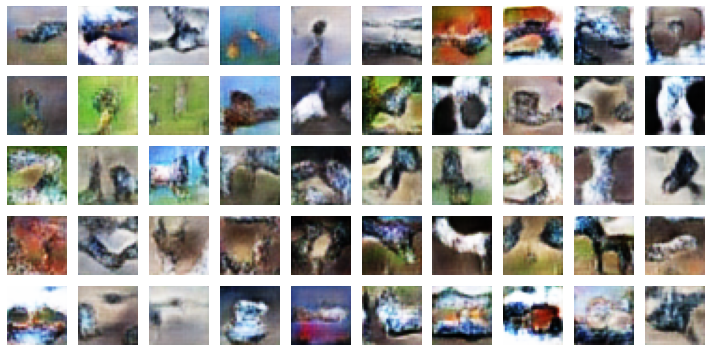

wandb: Adding directory to artifact (./Discriminator-Epoch35,KID=5.605418118648231e-05)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch35,KID=5.605418118648231e-05)... Done. 0.0s


782/782 [==============================] - 65s 83ms/step - d_loss: -0.7325 - g_loss: -2.8369 - val_kid: 5.6054e-05
Epoch 37/70
781/782 [============================>.] - ETA: 0s - d_loss: -0.9539 - g_loss: -2.7502

wandb: Adding directory to artifact (./Discriminator-Epoch36,KID=0.0007232435164041817)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch36,KID=0.0007232435164041817)... Done. 0.0s


782/782 [==============================] - 64s 82ms/step - d_loss: -0.9537 - g_loss: -2.7466 - val_kid: 7.2324e-04
Epoch 38/70
781/782 [============================>.] - ETA: 0s - d_loss: -1.3801 - g_loss: -2.4785

wandb: Adding directory to artifact (./Discriminator-Epoch37,KID=-0.00012753723422065377)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch37,KID=-0.00012753723422065377)... Done. 0.0s


782/782 [==============================] - 63s 81ms/step - d_loss: -1.3791 - g_loss: -2.4800 - val_kid: -1.2754e-04
Epoch 39/70
781/782 [============================>.] - ETA: 0s - d_loss: -0.9253 - g_loss: -4.3716

wandb: Adding directory to artifact (./Discriminator-Epoch38,KID=0.0003978522727265954)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch38,KID=0.0003978522727265954)... Done. 0.0s


782/782 [==============================] - 64s 82ms/step - d_loss: -0.9252 - g_loss: -4.3695 - val_kid: 3.9785e-04
Epoch 40/70
781/782 [============================>.] - ETA: 0s - d_loss: -0.8723 - g_loss: -1.5603

wandb: Adding directory to artifact (./Discriminator-Epoch39,KID=0.00012939599400851876)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch39,KID=0.00012939599400851876)... Done. 0.0s


782/782 [==============================] - 63s 81ms/step - d_loss: -0.8722 - g_loss: -1.5596 - val_kid: 1.2940e-04
Epoch 41/70
781/782 [============================>.] - ETA: 0s - d_loss: -0.8844 - g_loss: -1.8918

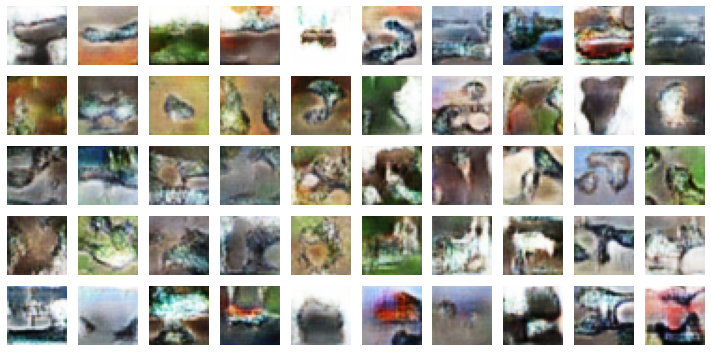

wandb: Adding directory to artifact (./Discriminator-Epoch40,KID=0.000136824935907498)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch40,KID=0.000136824935907498)... Done. 0.0s


782/782 [==============================] - 65s 83ms/step - d_loss: -0.8845 - g_loss: -1.8922 - val_kid: 1.3682e-04
Epoch 42/70
781/782 [============================>.] - ETA: 0s - d_loss: -0.9817 - g_loss: -3.1510

wandb: Adding directory to artifact (./Discriminator-Epoch41,KID=0.00013053797010798007)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch41,KID=0.00013053797010798007)... Done. 0.0s


782/782 [==============================] - 64s 82ms/step - d_loss: -0.9816 - g_loss: -3.1510 - val_kid: 1.3054e-04
Epoch 43/70
781/782 [============================>.] - ETA: 0s - d_loss: -0.8749 - g_loss: -4.5623

wandb: Adding directory to artifact (./Discriminator-Epoch42,KID=-0.00012454864918254316)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch42,KID=-0.00012454864918254316)... Done. 0.0s


782/782 [==============================] - 63s 81ms/step - d_loss: -0.8750 - g_loss: -4.5610 - val_kid: -1.2455e-04
Epoch 44/70
781/782 [============================>.] - ETA: 0s - d_loss: -1.0921 - g_loss: -3.8741

wandb: Adding directory to artifact (./Discriminator-Epoch43,KID=0.00017927862063515931)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch43,KID=0.00017927862063515931)... Done. 0.0s


782/782 [==============================] - 64s 81ms/step - d_loss: -1.0921 - g_loss: -3.8731 - val_kid: 1.7928e-04
Epoch 45/70
781/782 [============================>.] - ETA: 0s - d_loss: -1.3534 - g_loss: -9.9787

wandb: Adding directory to artifact (./Discriminator-Epoch44,KID=0.00013465638039633632)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch44,KID=0.00013465638039633632)... Done. 0.0s


782/782 [==============================] - 63s 81ms/step - d_loss: -1.3527 - g_loss: -9.9770 - val_kid: 1.3466e-04
Epoch 46/70
781/782 [============================>.] - ETA: 0s - d_loss: -1.0392 - g_loss: -8.0888

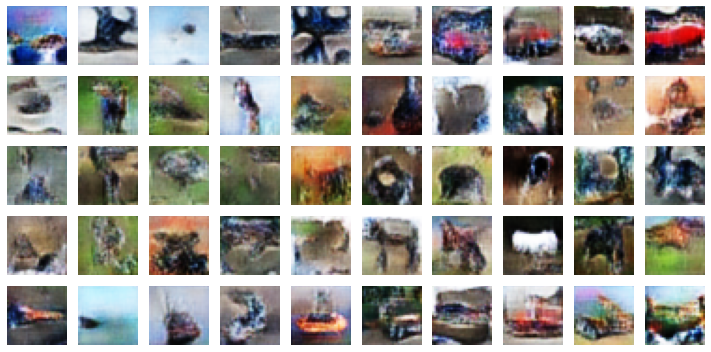

wandb: Adding directory to artifact (./Discriminator-Epoch45,KID=0.0001857538882177323)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch45,KID=0.0001857538882177323)... Done. 0.0s


782/782 [==============================] - 65s 83ms/step - d_loss: -1.0390 - g_loss: -8.0896 - val_kid: 1.8575e-04
Epoch 47/70
781/782 [============================>.] - ETA: 0s - d_loss: -0.4694 - g_loss: -4.2203

wandb: Adding directory to artifact (./Discriminator-Epoch46,KID=0.0003391861100681126)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch46,KID=0.0003391861100681126)... Done. 0.0s


782/782 [==============================] - 64s 81ms/step - d_loss: -0.4702 - g_loss: -4.2233 - val_kid: 3.3919e-04
Epoch 48/70
781/782 [============================>.] - ETA: 0s - d_loss: -0.6960 - g_loss: -5.8637

wandb: Adding directory to artifact (./Discriminator-Epoch47,KID=0.000250166398473084)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch47,KID=0.000250166398473084)... Done. 0.0s


782/782 [==============================] - 68s 86ms/step - d_loss: -0.6961 - g_loss: -5.8611 - val_kid: 2.5017e-04
Epoch 49/70
781/782 [============================>.] - ETA: 0s - d_loss: -0.6723 - g_loss: -0.5508

wandb: Adding directory to artifact (./Discriminator-Epoch48,KID=7.0098099058668595e-06)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch48,KID=7.0098099058668595e-06)... Done. 0.0s


782/782 [==============================] - 64s 81ms/step - d_loss: -0.6726 - g_loss: -0.5519 - val_kid: 7.0098e-06
Epoch 50/70
781/782 [============================>.] - ETA: 0s - d_loss: -0.9695 - g_loss: -1.5694

wandb: Adding directory to artifact (./Discriminator-Epoch49,KID=-5.8483925386099145e-05)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch49,KID=-5.8483925386099145e-05)... Done. 0.0s


782/782 [==============================] - 64s 81ms/step - d_loss: -0.9694 - g_loss: -1.5706 - val_kid: -5.8484e-05
Epoch 51/70
781/782 [============================>.] - ETA: 0s - d_loss: -0.6942 - g_loss: -5.9614

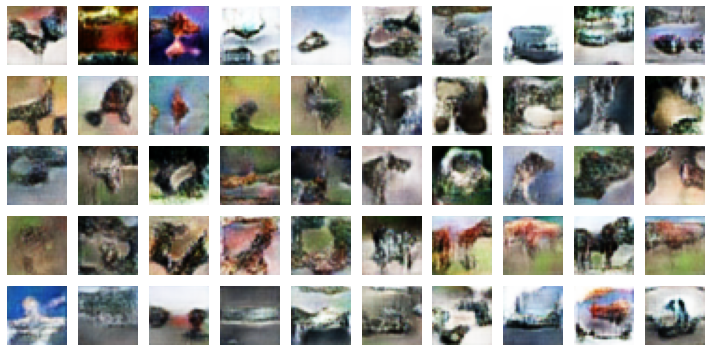

wandb: Adding directory to artifact (./Discriminator-Epoch50,KID=4.88074729219079e-05)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch50,KID=4.88074729219079e-05)... Done. 0.0s


782/782 [==============================] - 67s 85ms/step - d_loss: -0.6945 - g_loss: -5.9641 - val_kid: 4.8807e-05
Epoch 52/70
781/782 [============================>.] - ETA: 0s - d_loss: -0.6474 - g_loss: -3.0777

wandb: Adding directory to artifact (./Discriminator-Epoch51,KID=4.00543212890625e-05)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch51,KID=4.00543212890625e-05)... Done. 0.0s


782/782 [==============================] - 63s 81ms/step - d_loss: -0.6477 - g_loss: -3.0769 - val_kid: 4.0054e-05
Epoch 53/70
781/782 [============================>.] - ETA: 0s - d_loss: -0.9092 - g_loss: -2.9102

wandb: Adding directory to artifact (./Discriminator-Epoch52,KID=0.0002473904169164598)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch52,KID=0.0002473904169164598)... Done. 0.0s


782/782 [==============================] - 68s 87ms/step - d_loss: -0.9093 - g_loss: -2.9128 - val_kid: 2.4739e-04
Epoch 54/70
781/782 [============================>.] - ETA: 0s - d_loss: -0.6563 - g_loss: -4.3152

wandb: Adding directory to artifact (./Discriminator-Epoch53,KID=0.00022126459225546569)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch53,KID=0.00022126459225546569)... Done. 0.0s


782/782 [==============================] - 64s 81ms/step - d_loss: -0.6565 - g_loss: -4.3127 - val_kid: 2.2126e-04
Epoch 55/70
781/782 [============================>.] - ETA: 0s - d_loss: -0.7638 - g_loss: -2.1755

wandb: Adding directory to artifact (./Discriminator-Epoch54,KID=0.00019906280795112252)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch54,KID=0.00019906280795112252)... Done. 0.0s


782/782 [==============================] - 64s 82ms/step - d_loss: -0.7639 - g_loss: -2.1742 - val_kid: 1.9906e-04
Epoch 56/70
781/782 [============================>.] - ETA: 0s - d_loss: -0.8060 - g_loss: -1.3783

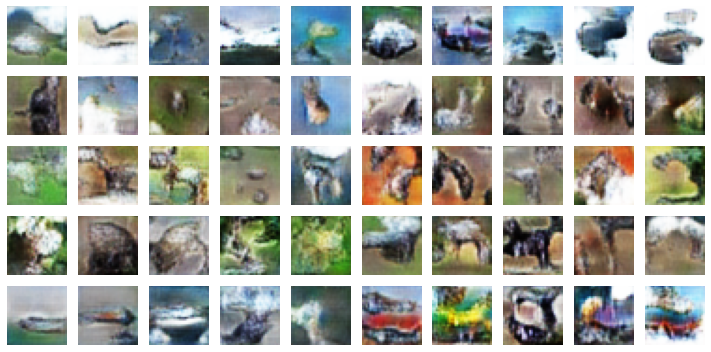

wandb: Adding directory to artifact (./Discriminator-Epoch55,KID=0.00031393501558341086)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch55,KID=0.00031393501558341086)... Done. 0.0s


782/782 [==============================] - 65s 83ms/step - d_loss: -0.8061 - g_loss: -1.3767 - val_kid: 3.1394e-04
Epoch 57/70
781/782 [============================>.] - ETA: 0s - d_loss: -0.8406 - g_loss: -0.7753

wandb: Adding directory to artifact (./Discriminator-Epoch56,KID=0.0003193290322087705)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch56,KID=0.0003193290322087705)... Done. 0.0s


782/782 [==============================] - 64s 82ms/step - d_loss: -0.8406 - g_loss: -0.7772 - val_kid: 3.1933e-04
Epoch 58/70
781/782 [============================>.] - ETA: 0s - d_loss: -0.9836 - g_loss: -3.1398

wandb: Adding directory to artifact (./Discriminator-Epoch57,KID=0.00017417616618331522)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch57,KID=0.00017417616618331522)... Done. 0.0s


782/782 [==============================] - 64s 82ms/step - d_loss: -0.9836 - g_loss: -3.1435 - val_kid: 1.7418e-04
Epoch 59/70
781/782 [============================>.] - ETA: 0s - d_loss: -0.6649 - g_loss: -1.3051

wandb: Adding directory to artifact (./Discriminator-Epoch58,KID=-7.885732338763773e-05)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch58,KID=-7.885732338763773e-05)... Done. 0.0s


782/782 [==============================] - 64s 82ms/step - d_loss: -0.6651 - g_loss: -1.3024 - val_kid: -7.8857e-05
Epoch 60/70
781/782 [============================>.] - ETA: 0s - d_loss: -0.8350 - g_loss: 0.9754

wandb: Adding directory to artifact (./Discriminator-Epoch59,KID=-0.00011798834020737559)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch59,KID=-0.00011798834020737559)... Done. 0.0s


782/782 [==============================] - 65s 83ms/step - d_loss: -0.8350 - g_loss: 0.9722 - val_kid: -1.1799e-04
Epoch 61/70
781/782 [============================>.] - ETA: 0s - d_loss: -1.0235 - g_loss: -3.0794

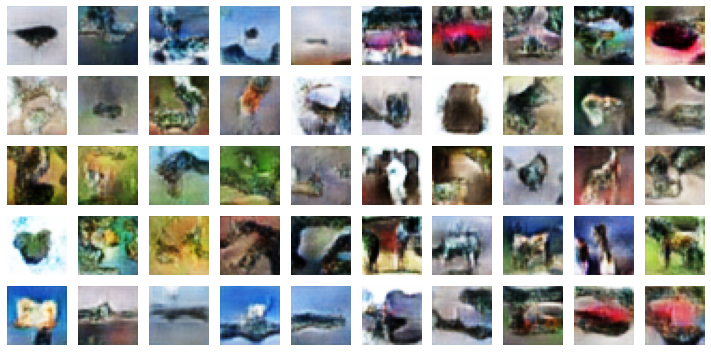

wandb: Adding directory to artifact (./Discriminator-Epoch60,KID=0.0005256142467260361)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch60,KID=0.0005256142467260361)... Done. 0.0s


782/782 [==============================] - 66s 84ms/step - d_loss: -1.0232 - g_loss: -3.0796 - val_kid: 5.2561e-04
Epoch 62/70
781/782 [============================>.] - ETA: 0s - d_loss: -1.1486 - g_loss: -1.0858

wandb: Adding directory to artifact (./Discriminator-Epoch61,KID=0.00031757354736328125)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch61,KID=0.00031757354736328125)... Done. 0.0s


782/782 [==============================] - 64s 82ms/step - d_loss: -1.1481 - g_loss: -1.0842 - val_kid: 3.1757e-04
Epoch 63/70
781/782 [============================>.] - ETA: 0s - d_loss: -0.6293 - g_loss: -1.6556

wandb: Adding directory to artifact (./Discriminator-Epoch62,KID=0.00031157207558862865)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch62,KID=0.00031157207558862865)... Done. 0.0s


782/782 [==============================] - 64s 82ms/step - d_loss: -0.6296 - g_loss: -1.6562 - val_kid: 3.1157e-04
Epoch 64/70
781/782 [============================>.] - ETA: 0s - d_loss: -0.7559 - g_loss: 0.8097

wandb: Adding directory to artifact (./Discriminator-Epoch63,KID=5.878157026018016e-05)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch63,KID=5.878157026018016e-05)... Done. 0.0s


782/782 [==============================] - 64s 82ms/step - d_loss: -0.7560 - g_loss: 0.8063 - val_kid: 5.8782e-05
Epoch 65/70
781/782 [============================>.] - ETA: 0s - d_loss: -0.7452 - g_loss: -3.8106

wandb: Adding directory to artifact (./Discriminator-Epoch64,KID=0.0004853230493608862)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch64,KID=0.0004853230493608862)... Done. 0.0s


782/782 [==============================] - 64s 82ms/step - d_loss: -0.7452 - g_loss: -3.8087 - val_kid: 4.8532e-04
Epoch 66/70
781/782 [============================>.] - ETA: 0s - d_loss: -0.7689 - g_loss: -2.1119

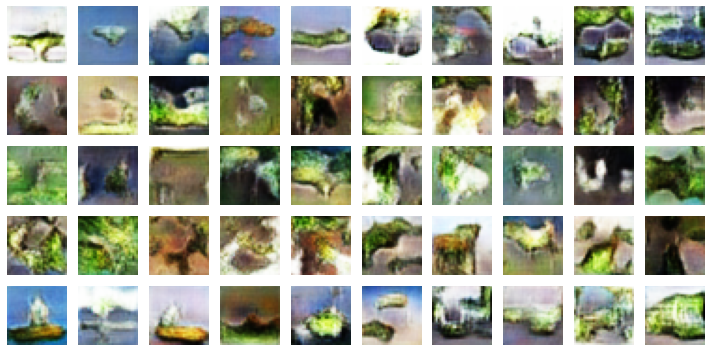

wandb: Adding directory to artifact (./Discriminator-Epoch65,KID=6.966682121856138e-05)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch65,KID=6.966682121856138e-05)... Done. 0.0s


782/782 [==============================] - 66s 84ms/step - d_loss: -0.7691 - g_loss: -2.1130 - val_kid: 6.9667e-05
Epoch 67/70
781/782 [============================>.] - ETA: 0s - d_loss: -0.7073 - g_loss: -5.9300

wandb: Adding directory to artifact (./Discriminator-Epoch66,KID=0.00021758352522738278)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch66,KID=0.00021758352522738278)... Done. 0.0s


782/782 [==============================] - 64s 82ms/step - d_loss: -0.7073 - g_loss: -5.9272 - val_kid: 2.1758e-04
Epoch 68/70
781/782 [============================>.] - ETA: 0s - d_loss: -0.9048 - g_loss: -2.1457

wandb: Adding directory to artifact (./Discriminator-Epoch67,KID=0.0010878690518438816)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch67,KID=0.0010878690518438816)... Done. 0.0s


782/782 [==============================] - 64s 82ms/step - d_loss: -0.9048 - g_loss: -2.1486 - val_kid: 0.0011
Epoch 69/70
781/782 [============================>.] - ETA: 0s - d_loss: -0.7587 - g_loss: 0.0458

wandb: Adding directory to artifact (./Discriminator-Epoch68,KID=5.6442942877765745e-05)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch68,KID=5.6442942877765745e-05)... Done. 0.0s


782/782 [==============================] - 64s 82ms/step - d_loss: -0.7587 - g_loss: 0.0465 - val_kid: 5.6443e-05
Epoch 70/70
781/782 [============================>.] - ETA: 0s - d_loss: -0.8425 - g_loss: -0.0379

wandb: Adding directory to artifact (./Discriminator-Epoch69,KID=0.00017681243480183184)... Done. 0.1s
wandb: Adding directory to artifact (./Generator-Epoch69,KID=0.00017681243480183184)... Done. 0.0s


782/782 [==============================] - 65s 83ms/step - d_loss: -0.8423 - g_loss: -0.0379 - val_kid: 1.7681e-04


In [ ]:

# Specify the optimizers


from tensorflow.keras.datasets.cifar10 import load_data

(x_train, y_train), (x_val, y_val)  = load_data() 
x_val =x_val / 255

# onehotimages =  tf.keras.utils.to_categorical(y_train, 10)
# Create a GAN object
gan = GAN(discriminator= discriminator() , generator=generator() , latdim = 128 , discriminator_extra_steps =5)

optimizers = {
	"d_optimizer": tf.keras.optimizers.Adam(learning_rate = 0.0002,beta_1=0.3 , beta_2 = 0.9),
	"g_optimizer": tf.keras.optimizers.Adam(learning_rate = 0.0002 , beta_1 =0.3 , beta_2 = 0.9  ),
}


# def wasserstein_loss(y_true, y_pred):
# 	return tf.reduce_mean(y_true*y_pred)
# Specify the losses and metrics
loss = {"d_loss": discriminator_loss , "g_loss": generator_loss} # trying wasserstein loss
# metrics = {"image_loss": metric_fn, "g_loss": None}

# Compile
gan.compile(optimizers=optimizers, loss=loss)
# Start the training and sit back
x_train =(x_train - 127.5) / 127.5
wandb.login(key = 'af6f4c85343fbc8359ab0fe7b2e1d8e4afd00896')
wandb.init(project =  'ConditionalW-GAN') 

history = gan.fit(x_train ,y_train , epochs=70, validation_data = (x_val , y_val), batch_size = 64 
				  
				 ,callbacks =  [
                    ImageLogger( latent_dim = 128, num_col = 10  , num_row = 5 ) ,
                    WandbModelLogger()]
				  
				  )

wandb.finish()
# fidhistory = gan.fid_history

In [7]:
import matplotlib.pyplot as plt 
def plotlearningcurve(history):
    plt.figure(figsize = (16,9))
    plt.subplot(121)
    plt.plot(history.history['d_loss'] , label = 'Discriminator Loss')
    plt.plot(history.history['g_loss'] , label = 'Generator Loss')
    plt.title('Learning Curve - loss')
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.legend( loc='upper left')

    plt.subplot(122)
    plt.plot(history.history['val_kid'] , label = 'KID')
    # plt.plot(history.history['val_loss'] , label = 'Validation Accuracy')
    plt.title('Learning Curve - KID')
    plt.ylabel('KID')
    plt.xlabel('Epoch')


    plt.legend( loc='upper left')
    plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt 

In [3]:
import wandb
api = wandb.Api()
run = api.run("yh1234/ConditionalW-GAN/ldoyfxwm")
history= run.history() 

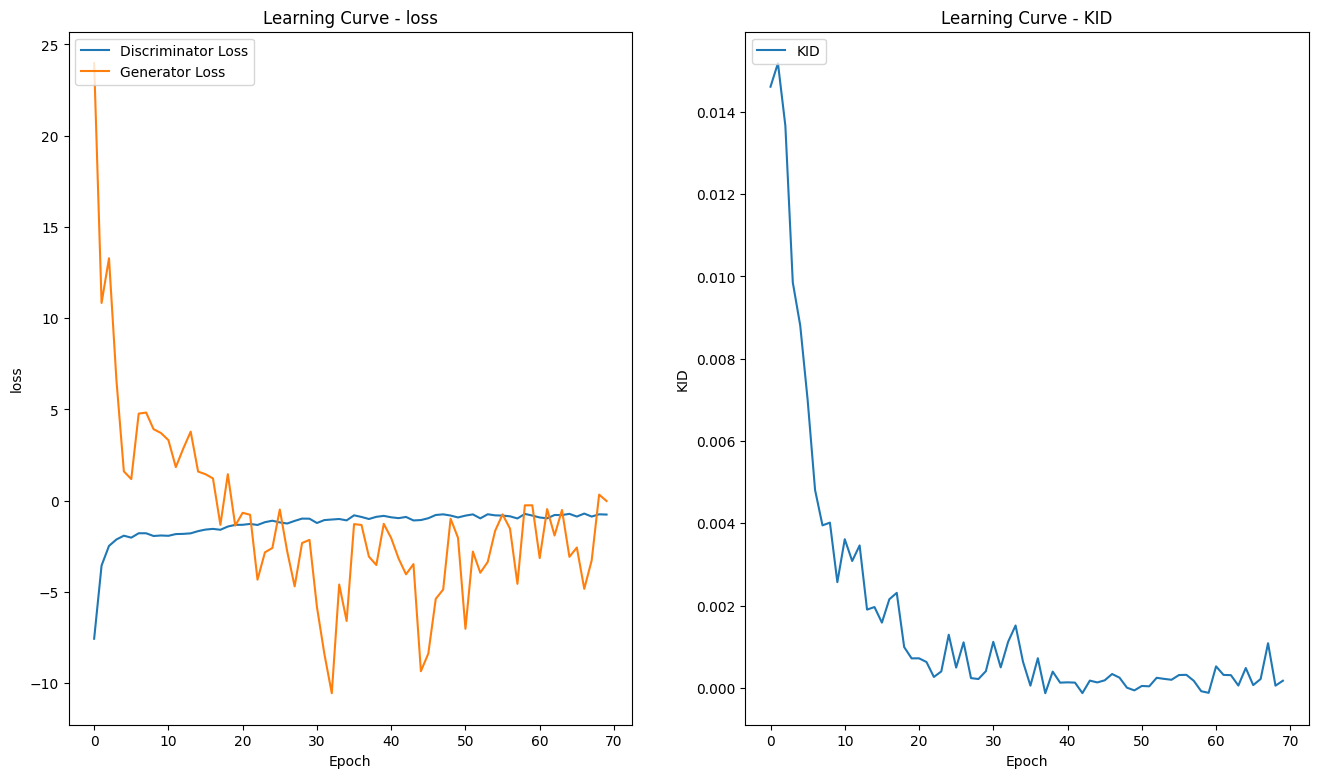

In [8]:

    
plotlearningcurve(history)

- In term of the generated images, the images from different classes look similar, showing mode collaspe , it also suggests that the conditioning method might not be working well 
- Kid decreases steadily and a lot more stable than the baseline
- Discriminator loss is stable 
- The generator loss is less stable and fluctuates more

- Attempt to find a more stable architecture of discriminator and generator


- Still poor image quality, but the general colors of each class can be seen
- blue sky for the plane and green grass land for the animal background

In [ ]:
import wandb
run = wandb.init()
artifact = run.use_artifact('yh1234/ConditionalW-GAN/Generator-lucky-springroll-24:v1', type='model')
artifact_dir = artifact.download()




wandb:   4 of 4 files downloaded.  


In [ ]:
generator = tf.keras.models.load_model(artifact_dir)

In [ ]:
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
# from skimage.transform import resize

def resizeforfid(image):
    image = 255*((image + 1)/2)
    image = tf.image.resize(image, (299, 299), method='nearest')
    image = tf.keras.applications.inception_v3.preprocess_input(image)

    return image
def calculate_fid(act1, act2):
    # calculate mean and covariance statistics
    #https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/
    incep= InceptionV3(include_top=False, pooling="avg", input_shape=(299,299,3))
    act1 = incep.predict(act1, verbose=0)
    act2 = incep.predict(act2, verbose=0)
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = numpy.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):          
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def preparefiddata(realimage, classeslabels, generator):
    realimages = tf.data.Dataset.from_tensor_slices(realimage).map(resizeforfid, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=128, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
    


    fakeimages = generator([tf.random.normal((len(realimage),128)),classeslabels ],training = False)

    fakeimgdataset =tf.data.Dataset.from_tensor_slices(fakeimages).map(resizeforfid, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=128, num_parallel_calls=tf.data.AUTOTUNE) .prefetch(tf.data.AUTOTUNE)

    return calculate_fid(realimages, fakeimgdataset)

In [ ]:
from tensorflow.keras.datasets.cifar10 import load_data
(x_train, y_train), (x_val, y_val)  = load_data() 
x_val  = (x_val -127.5)/127.5
fidscore = preparefiddata(x_val, y_val, generator)
print(fidscore)

69.69465276056351


#### FID 
FID score of 69 shows a large room of improvement

- Training speed seems to be slow/ gradient penalty calculations are very 